<a href="https://colab.research.google.com/github/oddissea/pfg/blob/main/siren_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/PFG/assets/'
PATH_OUTPUTS = PATH + 'outputs/'
SRC_PATH = PATH + 'src/'
IMG_PATH = PATH + 'images/sol.h5'

# Nueva sección

In [ ]:
import os, imageio
import tqdm.auto
import numpy as np
import torch
import torch.nn as nn


from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

from PIL import Image

In [ ]:
# Cambiar de directorio
os.chdir(SRC_PATH)
import utils as utils
import training as tr
import models as m
import dataset as ds
import siren as sr

from utils import *
from training import *
from models import *
from dataset import *
from siren import *

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
cube = utils.get_data(IMG_PATH)
NUM_IMAGES = cube.shape[0]

# Etiquetas para las longitudes de onda
wl_lbls = [f'λ = {l + 1}' for l in np.arange(0, NUM_IMAGES)]

Primera clave: cube


In [ ]:
CROP_SIZE = 256
IMAGE_INDEX = 4

In [ ]:
FOURIER_DIM = 128
FOURIER_SCALE = 25.
INPUT_DIMS = 2 * FOURIER_DIM

B = FOURIER_SCALE * torch.randn(size=(2, FOURIER_DIM), requires_grad=False).to(device)

In [ ]:
# Obtenemos una de las imágenes
image = utils.get_experiment_data(cube, IMAGE_INDEX)
# La recortamos creando un patch de (CROP_SIZE x CROP_SIZE)
image = utils.crop(image, CROP_SIZE)
# Normalizamos los valores de la intensidad de los píxeles al intervalo [0, 1]
image, (min, max) = utils.feat_scaling(image)
# obtenemos la malla de coordenadas normalizadas al intevalo [0, 1]
x = np.linspace(0, 1, image.shape[2], endpoint=False)
grid = torch.tensor(np.stack(np.meshgrid(x, x), -1), dtype=torch.float32)

In [ ]:
# img = Image.open("lenna.png")

In [ ]:
# img.size

In [ ]:
# transformations = transforms.Compose([transforms.Resize(256), transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

In [ ]:
# y = transformations(image).reshape(3, -1).transpose(0, 1)
# y.shape

In [ ]:
# g0, g1 = torch.meshgrid([torch.arange(-1, 1, step = 2 / 256), torch.arange(-1, 1, step = 2 / 256)])
# x = torch.cat([g0.flatten().unsqueeze(1), g1.flatten().unsqueeze(1)], dim = 1)
# x = x.float()
# x.shape

In [ ]:
X, Y = [grid.view(-1, 2), image.view(-1, 1)]
dataset = TensorDataset(X, Y)

In [ ]:
dataloader = DataLoader(dataset, batch_size = 4096, shuffle = True, pin_memory = True)

In [ ]:
model_siren = sr.SirenModel(layer_dims = [2, 256, 128, 64, 32, 1]).to(device)
model_features = sr.NeuralField(hidden_layers=2, neurons_per_layer=INPUT_DIMS, input_dimension=INPUT_DIMS).to(device)

In [ ]:
model_siren.train()

SirenModel(
  (layers): ModuleList(
    (0-2): 3 x SirenLayer()
  )
)

In [ ]:
model_features.train()

NeuralField(
  (input_layer): Linear(in_features=256, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
optimizer_siren = torch.optim.Adam(model_siren.parameters(), lr = 0.0005)
optimizer_features = torch.optim.Adam(model_features.parameters(), lr = 0.0005)

In [ ]:
criterion = torch.nn.MSELoss()

In [ ]:
def training(dataloader, optimizer, criterion, model, B=None, fourier=False):
  for epoch in tqdm(range(300)):
      losses = []
      for batch in dataloader:
          inputs, targets = batch
          inputs, targets = inputs.to(device), targets.to(device)
          if fourier:
            inputs = sr.apply_fourier_features(inputs, B)
          predictions = model(inputs)
          loss = criterion(predictions, targets)
          losses.append(loss.reshape(-1))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      avg_loss = torch.mean(torch.cat(losses)).item()
      if epoch % 25 == 0:
        print("{} -> {:.4f}".format(epoch, avg_loss))
  return model

In [ ]:
out_features = training(dataloader, optimizer_features, criterion, model_features, B, True)

  0%|          | 0/300 [00:00<?, ?it/s]

0 -> 0.0111
25 -> 0.0001
50 -> 0.0000
75 -> 0.0000
100 -> 0.0000
125 -> 0.0000
150 -> 0.0000
175 -> 0.0000
200 -> 0.0000
225 -> 0.0000
250 -> 0.0000
275 -> 0.0000


In [ ]:
out_siren = training(dataloader, optimizer_siren, criterion, model_siren)

  0%|          | 0/300 [00:00<?, ?it/s]

0 -> 0.3765
25 -> 0.0010
50 -> 0.0006
75 -> 0.0005
100 -> 0.0004
125 -> 0.0004
150 -> 0.0004
175 -> 0.0004
200 -> 0.0004
225 -> 0.0004
250 -> 0.0004
275 -> 0.0004


In [ ]:
def out(res, B=None, fourier=False):
  with torch.no_grad():
    if fourier:
      inputs = sr.apply_fourier_features(X.to(device), B)
    else:
      inputs = X.to(device)
    test_y = res(inputs).cpu()
    test_y = test_y.transpose(0, 1).reshape(1, 256, 256)
  return test_y

In [ ]:
test_siren = out(out_siren)
test_features = out(out_features, B, True)
print(f'siren_shape: {test_siren.shape} - image_shape: {image.shape}')
print(f'features_shape: {test_features.shape} - image_shape: {image.shape}')

siren_shape: torch.Size([1, 256, 256]) - image_shape: torch.Size([1, 1, 256, 256])
features_shape: torch.Size([1, 256, 256]) - image_shape: torch.Size([1, 1, 256, 256])


In [ ]:
def psnr(gt, pred):
  return -10 * torch.log10(2. * torch.mean((gt - pred) ** 2.))

tensor(31.6622)


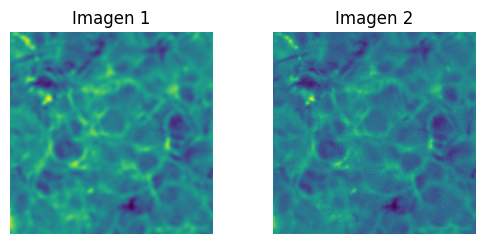

(2, 256, 256)
Rango dinámico: (0.0, 1.0)



In [ ]:
print(psnr(test_siren, image.squeeze(0)))
concat = torch.cat((test_siren, image.squeeze(0)), 0)
concat = concat.squeeze().numpy()
utils.plot_data(concat)

tensor(39.6713)


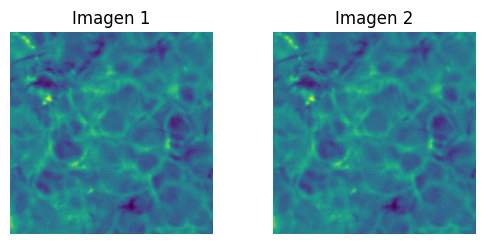

(2, 256, 256)
Rango dinámico: (0.0, 1.0)



In [ ]:
print(psnr(test_features, image.squeeze(0)))
concat = torch.cat((test_features, image.squeeze(0)), 0)
concat = concat.squeeze().numpy()
utils.plot_data(concat)

In [ ]:
# torch.save({'model' : model}, 'siren.cpt')